#**Multi-class Comparison between Choroidal Neovascularization, Diabetic Macular Edema, Drusen, and Normal** ---------------------------------A cure for blindness


---

![alt text](https://cdn.cnn.com/cnnnext/dam/assets/160325143340-andrew-bastawrous-3-super-169.jpg)


## **Abstract** : 
Retinal optical coherence tomography (OCT) is an imaging technique used to capture high-resolution cross sections of the retinas of living patients. 
These three diease 



1. #### **Choroidal neovascularization (CNV)** involves the growth of new blood vessels that originate from the choroid through a break in the Bruch membrane into the sub–retinal pigment epithelium (sub-RPE) or subretinal space. CNV is a major cause of visual loss.
2. #### **Diabetic Macular Edema (DME)** is an accumulation of fluid in the macula part of the retina that controls our most detailed vision abilities—due to leaking blood vessels.
3. #### **Drusen** are yellow deposits under the retina. Drusen are made up of lipids and proteins. Drusen likely do not cause age-related macular degeneration (AMD). But having drusen increases a person's risk of developing AMD



Aim of the notebook was for devloping the deep-learning framework for the screening of patients with common treatable blinding retinal diseases



In [0]:
# Import neccessary library
import matplotlib.pyplot as plt
import tensorflow as tf
import numpy as np
import pandas as pd
import os
import pathlib

In [0]:
from tensorflow.compat.v1 import ConfigProto
from tensorflow.compat.v1 import InteractiveSession
config = ConfigProto()
config.gpu_options.allow_growth = True
session = InteractiveSession(config=config)

In [3]:
# Dowload the required data

!wget https://data.mendeley.com/datasets/rscbjbr9sj/2/files/5699a1d8-d1b6-45db-bb92-b61051445347/OCT2017.tar.gz?dl=1 \
    -O /OCT2017

--2020-04-05 00:49:37--  https://data.mendeley.com/datasets/rscbjbr9sj/2/files/5699a1d8-d1b6-45db-bb92-b61051445347/OCT2017.tar.gz?dl=1
Resolving data.mendeley.com (data.mendeley.com)... 162.159.133.86, 162.159.130.86, 2606:4700:7::a29f:8556, ...
Connecting to data.mendeley.com (data.mendeley.com)|162.159.133.86|:443... connected.
HTTP request sent, awaiting response... 302 Found
Location: https://md-datasets-public-files-prod.s3.eu-west-1.amazonaws.com/9cfd5550-a37d-4404-9441-860ee091bc67 [following]
--2020-04-05 00:49:37--  https://md-datasets-public-files-prod.s3.eu-west-1.amazonaws.com/9cfd5550-a37d-4404-9441-860ee091bc67
Resolving md-datasets-public-files-prod.s3.eu-west-1.amazonaws.com (md-datasets-public-files-prod.s3.eu-west-1.amazonaws.com)... 52.218.98.64
Connecting to md-datasets-public-files-prod.s3.eu-west-1.amazonaws.com (md-datasets-public-files-prod.s3.eu-west-1.amazonaws.com)|52.218.98.64|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 5793183

In [0]:
# extract the tar file
import tarfile
tar = tarfile.open("/OCT2017")
tar.extractall()
tar.close()  

In [5]:
# Organizing paths of data locations
main_path = pathlib.Path(r"OCT2017")
train_path = main_path / 'train'
test_path = main_path / 'test'
val_path = main_path / 'val'

train_path

PosixPath('OCT2017/train')

In [6]:
# Directory with our training horse pictures
train_eye_dir = os.path.join( main_path / 'train')

# Directory with our validation eye pictures
validation_eye_dir = os.path.join(main_path / 'val')

# Directory with our test eye pictures
test_eye_dir = os.path.join(main_path / 'test')
train_eye_dir

'OCT2017/train'

In [7]:
import random
import pathlib
train_image_paths = [str(path) for path in list(train_path.glob('*/*.jpeg'))]
random.shuffle(train_image_paths)
test_image_paths = [str(path) for path in list(test_path.glob('*/*.jpeg'))]
val_image_paths = [str(path) for path in list(val_path.glob('*/*.jpeg'))]


print('Number of training images:', len(train_image_paths))
print('Number of testing images:', len(test_image_paths))
print('Number of validation images:', len(val_image_paths))

Number of training images: 83484
Number of testing images: 1000
Number of validation images: 0


In [0]:
import tensorflow as tf

In [0]:
model_basic = tf.keras.models.Sequential([
    # input shape is the desired size of the image 150x150 with 3 bytes color
    # This is the first convolution
    tf.keras.layers.Conv2D(32, (7,7), activation='relu', input_shape=(150, 150, 3)),
    tf.keras.layers.MaxPooling2D(2, 2),
    # The second convolution
    tf.keras.layers.Conv2D(16, (5,5), activation='relu'),
    tf.keras.layers.MaxPooling2D(2,2),
    # The third convolution
    tf.keras.layers.Conv2D(8, (3,3), activation='relu'),
    tf.keras.layers.MaxPooling2D(2,2),
    # Flatten the results to feed into a DNN
    tf.keras.layers.Flatten(),
    # 200 neuron hidden layer
    tf.keras.layers.Dense(1000, activation='relu'),
    tf.keras.layers.Dense(200, activation='relu'),
    tf.keras.layers.Dense(4, activation='softmax')
])

In [10]:
model_basic.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d (Conv2D)              (None, 144, 144, 32)      4736      
_________________________________________________________________
max_pooling2d (MaxPooling2D) (None, 72, 72, 32)        0         
_________________________________________________________________
conv2d_1 (Conv2D)            (None, 68, 68, 16)        12816     
_________________________________________________________________
max_pooling2d_1 (MaxPooling2 (None, 34, 34, 16)        0         
_________________________________________________________________
conv2d_2 (Conv2D)            (None, 32, 32, 8)         1160      
_________________________________________________________________
max_pooling2d_2 (MaxPooling2 (None, 16, 16, 8)         0         
_________________________________________________________________
flatten (Flatten)            (None, 2048)              0

In [0]:
from tensorflow.keras.optimizers import RMSprop

model_basic.compile(loss='mse',
              optimizer=RMSprop(lr=0.001),
              metrics=['acc'])

In [12]:
from tensorflow.keras.preprocessing.image import ImageDataGenerator

# All images will be rescaled by 1./255
train_datagen = ImageDataGenerator(rescale=1/255)
test_datagen = ImageDataGenerator(rescale=1/255)

# Flow training images in batches of 128 using train_datagen generator
train_generator = train_datagen.flow_from_directory(
        'OCT2017/train/',  # This is the source directory for training images
        target_size=(150, 150),  # All images will be resized to 150x150
        batch_size=64,
        # Since we use binary_crossentropy loss, we need binary labels
        class_mode='categorical')



# Flow training images in batches of 128 using train_datagen generator
test_generator = test_datagen.flow_from_directory(
        'OCT2017/test',  # This is the source directory for training images
        target_size=(150, 150),  # All images will be resized to 150x150
        batch_size=20,
        # Since we use binary_crossentropy loss, we need binary labels
        class_mode='categorical')

Found 83484 images belonging to 4 classes.
Found 1000 images belonging to 4 classes.


In [0]:
history = model_basic.fit_generator(
      train_generator,
      steps_per_epoch=len(train_image_paths)//64,  
      epochs=30,
      verbose=1,
      validation_data = test_generator,
      validation_steps=len(test_image_paths)//20      
      )


Epoch 1/30
1304/1304 [==============================] - 363s 278ms/step - loss: 0.0927 - acc: 0.7376 - val_loss: 0.1056 - val_acc: 0.7020
Epoch 2/30
1304/1304 [==============================] - 313s 240ms/step - loss: 0.0588 - acc: 0.8402 - val_loss: 0.0455 - val_acc: 0.8770
Epoch 3/30
1304/1304 [==============================] - 260s 199ms/step - loss: 0.0483 - acc: 0.8726 - val_loss: 0.0312 - val_acc: 0.9200
Epoch 4/30
1304/1304 [==============================] - 254s 195ms/step - loss: 0.0396 - acc: 0.8970 - val_loss: 0.0269 - val_acc: 0.9290
Epoch 5/30
1304/1304 [==============================] - 252s 193ms/step - loss: 0.0332 - acc: 0.9155 - val_loss: 0.0167 - val_acc: 0.9590
Epoch 6/30
1304/1304 [==============================] - 252s 193ms/step - loss: 0.0289 - acc: 0.9272 - val_loss: 0.0450 - val_acc: 0.8840
Epoch 7/30
1304/1304 [==============================] - 254s 195ms/step - loss: 0.0252 - acc: 0.9373 - val_loss: 0.0097 - val_acc: 0.9760
Epoch 8/30
1304/1304 [============

### Trying with different Epoch of 15  with stopping fucntion at 97% accuracy

###Defining **Callback** for stoping training after 97% accuracy

In [0]:
class myCallback(tf.keras.callbacks.Callback):
        def on_epoch_end(self, epoch, logs={}):
            if(logs.get('acc')>0.97):
              print("\nReached 97% accuracy so cancelling training!")
              self.model.stop_training = True

callbacks = myCallback()

In [0]:
model_ep = tf.keras.models.Sequential([
    # Note the input shape is the desired size of the image 150x150 with 3 bytes color
    # This is the first convolution
    tf.keras.layers.Conv2D(32, (7,7), activation='relu', input_shape=(150, 150, 3)),
    tf.keras.layers.MaxPooling2D(2, 2),
    # The second convolution
    tf.keras.layers.Conv2D(16, (5,5), activation='relu'),
    tf.keras.layers.MaxPooling2D(2,2),
    # The third convolution
    tf.keras.layers.Conv2D(8, (3,3), activation='relu'),
    tf.keras.layers.MaxPooling2D(2,2),
    # Flatten the results to feed into a DNN
    tf.keras.layers.Flatten(),
    # 200 neuron hidden layer
    tf.keras.layers.Dense(1000, activation='relu'),
    tf.keras.layers.Dense(200, activation='relu'),n
    tf.keras.layers.Dense(4, activation='softmax')
])

from tensorflow.keras.optimizers import RMSprop

model_ep.compile(loss='mse',
              optimizer=RMSprop(lr=0.001),
              metrics=['acc'])

history = model_ep.fit_generator(
      train_generator,
      steps_per_epoch=len(train_image_paths)//64,  
      epochs=15,
      verbose=1,
      validation_data = test_generator,
      validation_steps=len(test_image_paths)//20,
      callbacks=[callbacks]      
      )


Epoch 1/15
1304/1304 [==============================] - 246s 189ms/step - loss: 0.0881 - acc: 0.7520 - val_loss: 0.0647 - val_acc: 0.8270
Epoch 2/15
1304/1304 [==============================] - 246s 189ms/step - loss: 0.0569 - acc: 0.8465 - val_loss: 0.0415 - val_acc: 0.8900
Epoch 3/15
1304/1304 [==============================] - 245s 188ms/step - loss: 0.0452 - acc: 0.8813 - val_loss: 0.0232 - val_acc: 0.9370
Epoch 4/15
1304/1304 [==============================] - 245s 188ms/step - loss: 0.0370 - acc: 0.9043 - val_loss: 0.0194 - val_acc: 0.9550
Epoch 5/15
1304/1304 [==============================] - 247s 190ms/step - loss: 0.0307 - acc: 0.9226 - val_loss: 0.0231 - val_acc: 0.9390
Epoch 6/15
1304/1304 [==============================] - 248s 190ms/step - loss: 0.0261 - acc: 0.9350 - val_loss: 0.0178 - val_acc: 0.9530
Epoch 7/15
1304/1304 [==============================] - 246s 189ms/step - loss: 0.0230 - acc: 0.9429 - val_loss: 0.0174 - val_acc: 0.9600
Epoch 8/15
1304/1304 [============

Network plateaued with 97% at 15 epoch

###Using other Activation fucntion - TanH



In [0]:
model_act = tf.keras.models.Sequential([
    # Note the input shape is the desired size of the image 150x150 with 3 bytes color
    # This is the first convolution
    tf.keras.layers.Conv2D(32, (7,7), activation='tanh', input_shape=(150, 150, 3)),
    tf.keras.layers.MaxPooling2D(2, 2),
    # The second convolution
    tf.keras.layers.Conv2D(16, (5,5), activation='tanh'),
    tf.keras.layers.MaxPooling2D(2,2),
    tf.keras.layers.Conv2D(8, (3,3), activation='tanh'),
    tf.keras.layers.MaxPooling2D(2,2),
    # Flatten the results to feed into a DNN
    tf.keras.layers.Flatten(),
    # 512 neuron hidden layer
    tf.keras.layers.Dense(1000, activation='tanh'),
    tf.keras.layers.Dense(200, activation='tanh'),
    tf.keras.layers.Dense(4, activation='softmax')
])

In [0]:
from tensorflow.keras.optimizers import RMSprop

model_act.compile(loss='mse',
              optimizer=RMSprop(lr=0.001),
              metrics=['acc'])

history = model_act.fit_generator(
      train_generator,
      steps_per_epoch=len(train_image_paths)//64,  
      epochs=15,
      verbose=1,
      validation_data = test_generator,
      validation_steps=len(test_image_paths)//20,
      callbacks=[callbacks]      
      )

Epoch 1/15
1304/1304 [==============================] - 261s 200ms/step - loss: 0.1792 - acc: 0.4219 - val_loss: 0.2005 - val_acc: 0.2370
Epoch 2/15
1304/1304 [==============================] - 268s 205ms/step - loss: 0.1479 - acc: 0.5354 - val_loss: 0.1299 - val_acc: 0.6000
Epoch 3/15
1304/1304 [==============================] - 270s 207ms/step - loss: 0.0774 - acc: 0.7872 - val_loss: 0.0591 - val_acc: 0.8420
Epoch 4/15
1304/1304 [==============================] - 266s 204ms/step - loss: 0.0589 - acc: 0.8408 - val_loss: 0.0418 - val_acc: 0.8850
Epoch 5/15
1304/1304 [==============================] - 271s 208ms/step - loss: 0.0492 - acc: 0.8700 - val_loss: 0.0294 - val_acc: 0.9250
Epoch 6/15
1304/1304 [==============================] - 273s 209ms/step - loss: 0.0407 - acc: 0.8932 - val_loss: 0.0214 - val_acc: 0.9440
Epoch 7/15
1304/1304 [==============================] - 269s 206ms/step - loss: 0.0346 - acc: 0.9108 - val_loss: 0.0205 - val_acc: 0.9440
Epoch 8/15
1304/1304 [============

Using Tanh function reduced the the accuracy to 96.56 from 97%

### Other Gradient estimation -  **Stochastic gradient descent**

In [0]:
model_gd = tf.keras.models.Sequential([
    # Note the input shape is the desired size of the image 150x150 with 3 bytes color
    # This is the first convolution
    tf.keras.layers.Conv2D(32, (7,7), activation='relu', input_shape=(150, 150, 3)),
    tf.keras.layers.MaxPooling2D(2, 2),
    # The second convolution
    tf.keras.layers.Conv2D(16, (5,5), activation='relu'),
    tf.keras.layers.MaxPooling2D(2,2),
    tf.keras.layers.Conv2D(8, (3,3), activation='relu'),
    tf.keras.layers.MaxPooling2D(2,2),
    # Flatten the results to feed into a DNN
    tf.keras.layers.Flatten(),
    # 512 neuron hidden layer
    tf.keras.layers.Dense(1000, activation='relu'),
    tf.keras.layers.Dense(200, activation='relu'),
    tf.keras.layers.Dense(4, activation='softmax')
])

from tensorflow.keras.optimizers import SGD

model_gd.compile(loss='mse',
              optimizer=SGD(lr=0.001),
              metrics=['acc'])

history = model_gd.fit_generator(
      train_generator,
      steps_per_epoch=len(train_image_paths)//64,  
      epochs= 30,
      verbose=1,
      validation_data = test_generator,
      validation_steps=len(test_image_paths)//20,
       callbacks=[callbacks]       
      )

Instructions for updating:
Please use Model.fit, which supports generators.
Epoch 1/30
1304/1304 [==============================] - 342s 262ms/step - loss: 0.1740 - acc: 0.4341 - val_loss: 0.2002 - val_acc: 0.2500
Epoch 2/30
1304/1304 [==============================] - 294s 226ms/step - loss: 0.1656 - acc: 0.4598 - val_loss: 0.2026 - val_acc: 0.3130
Epoch 3/30
1304/1304 [==============================] - 261s 200ms/step - loss: 0.1640 - acc: 0.4869 - val_loss: 0.2018 - val_acc: 0.3490
Epoch 4/30
1304/1304 [==============================] - 257s 197ms/step - loss: 0.1625 - acc: 0.5042 - val_loss: 0.1986 - val_acc: 0.3940
Epoch 5/30
1304/1304 [==============================] - 257s 197ms/step - loss: 0.1608 - acc: 0.5189 - val_loss: 0.2007 - val_acc: 0.3730
Epoch 6/30
1304/1304 [==============================] - 255s 196ms/step - loss: 0.1584 - acc: 0.5321 - val_loss: 0.1942 - val_acc: 0.4100
Epoch 7/30
1304/1304 [==============================] - 253s 194ms/step - loss: 0.1553 - acc: 0.

Using Stochastic gradient descent, this makes network to take more time to plateau. Even after 30 epcoh it will not converege.

###Trying with different architecture

In [0]:
modelt = tf.keras.models.Sequential([
    # Note the input shape is the desired size of the image 150x150 with 3 bytes color
    # This is the first convolution
    tf.keras.layers.Conv2D(64, (14,14), activation='relu', input_shape=(150, 150, 3)),
    tf.keras.layers.MaxPooling2D(2, 2),
    tf.keras.layers.Conv2D(32, (7,7), activation='relu', input_shape=(150, 150, 3)),
    tf.keras.layers.MaxPooling2D(2, 2),
    # The second convolution
    tf.keras.layers.Conv2D(16, (5,5), activation='relu'),
    tf.keras.layers.MaxPooling2D(2,2),
    tf.keras.layers.Conv2D(8, (3,3), activation='relu'),
    tf.keras.layers.MaxPooling2D(2,2),
    # Flatten the results to feed into a DNN
    tf.keras.layers.Flatten(),

    tf.keras.layers.Dense(200, activation='relu'),
    tf.keras.layers.Dense(4, activation='softmax')
])

modelt.summary()

from tensorflow.keras.optimizers import RMSprop

modelt.compile(loss='mse',
              optimizer=RMSprop(lr=0.001),
              metrics=['acc'])

hit2 = modelt.fit_generator(
      train_generator,
      steps_per_epoch=len(train_image_paths)//64,  
      epochs=25,
      verbose=1,
      validation_data = test_generator,
      validation_steps=len(test_image_paths)//20,
       callbacks=[callbacks]       
      )

Model: "sequential_7"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_21 (Conv2D)           (None, 137, 137, 64)      37696     
_________________________________________________________________
max_pooling2d_21 (MaxPooling (None, 68, 68, 64)        0         
_________________________________________________________________
conv2d_22 (Conv2D)           (None, 62, 62, 32)        100384    
_________________________________________________________________
max_pooling2d_22 (MaxPooling (None, 31, 31, 32)        0         
_________________________________________________________________
conv2d_23 (Conv2D)           (None, 27, 27, 16)        12816     
_________________________________________________________________
max_pooling2d_23 (MaxPooling (None, 13, 13, 16)        0         
_________________________________________________________________
conv2d_24 (Conv2D)           (None, 11, 11, 8)        

Adding one more extra layer lead to decrease in the accuracy to 94% from 97%.

Changing the weight 

In [0]:
tf.keras.initializers.TruncatedNormal(
    mean=0.0, stddev=0.05, seed=None
)

model_int = tf.keras.models.Sequential([
    # Note the input shape is the desired size of the image 150x150 with 3 bytes color
    # This is the first convolution
    tf.keras.layers.Conv2D(32, (7,7), activation='relu', input_shape=(150, 150, 3)),
    tf.keras.layers.MaxPooling2D(2, 2),
    # The second convolution
    tf.keras.layers.Conv2D(16, (5,5), activation='relu'),
    tf.keras.layers.MaxPooling2D(2,2),
    # The third convolution
    tf.keras.layers.Conv2D(8, (3,3), activation='relu'),
    tf.keras.layers.MaxPooling2D(2,2),
    # Flatten the results to feed into a DNN
    tf.keras.layers.Flatten(),
    # 512 neuron hidden layer
    tf.keras.layers.Dense(1000, activation='relu'),
    tf.keras.layers.Dense(200, activation='relu'),
    tf.keras.layers.Dense(4, activation='softmax')
])

from tensorflow.keras.optimizers import RMSprop

model_int.compile(loss='mse',
              optimizer=RMSprop(lr=0.001),
              metrics=['acc'])

history = model_int.fit_generator(
      train_generator,
      steps_per_epoch=len(train_image_paths)//64,  
      epochs=30,
      verbose=1,
      validation_data = test_generator,
      validation_steps=len(test_image_paths)//20,
             callbacks=[callbacks]       
     
      )

Epoch 1/30
1304/1304 [==============================] - 303s 232ms/step - loss: 0.0552 - acc: 0.8523 - val_loss: 0.0445 - val_acc: 0.8830
Epoch 3/30
1304/1304 [==============================] - 258s 198ms/step - loss: 0.0429 - acc: 0.8884 - val_loss: 0.0314 - val_acc: 0.9110
Epoch 4/30
1304/1304 [==============================] - 253s 194ms/step - loss: 0.0350 - acc: 0.9102 - val_loss: 0.0193 - val_acc: 0.9490
Epoch 5/30
1304/1304 [==============================] - 252s 193ms/step - loss: 0.0292 - acc: 0.9263 - val_loss: 0.0138 - val_acc: 0.9660
Epoch 6/30
1304/1304 [==============================] - 251s 193ms/step - loss: 0.0252 - acc: 0.9378 - val_loss: 0.0176 - val_acc: 0.9560
Epoch 7/30
1304/1304 [==============================] - 251s 193ms/step - loss: 0.0222 - acc: 0.9458 - val_loss: 0.0157 - val_acc: 0.9620
Epoch 8/30
1304/1304 [==============================] - 251s 192ms/step - loss: 0.0194 - acc: 0.9533 - val_loss: 0.0096 - val_acc: 0.9780
Epoch 9/30
1304/1304 [============

Changing the the intial weight not much change with out accuracy but network convereged sooner than the default weight.

Trying with different Cost function MAE Mean Absolute Error

In [16]:
model_int = tf.keras.models.Sequential([
    # Note the input shape is the desired size of the image 150x150 with 3 bytes color
    # This is the first convolution
    tf.keras.layers.Conv2D(32, (7,7), activation='relu', input_shape=(150, 150, 3)),
    tf.keras.layers.MaxPooling2D(2, 2),
    # The second convolution
    tf.keras.layers.Conv2D(16, (5,5), activation='relu'),
    tf.keras.layers.MaxPooling2D(2,2),
    # The third convolution
    tf.keras.layers.Conv2D(8, (3,3), activation='relu'),
    tf.keras.layers.MaxPooling2D(2,2),
    # Flatten the results to feed into a DNN
    tf.keras.layers.Flatten(),
    # 512 neuron hidden layer
    tf.keras.layers.Dense(1000, activation='relu'),
    tf.keras.layers.Dense(200, activation='relu'),
    tf.keras.layers.Dense(4, activation='softmax')
])

from tensorflow.keras.optimizers import RMSprop

model_int.compile(loss='mae',
              optimizer=RMSprop(lr=0.001),
              metrics=['acc'])

history = model_int.fit_generator(
      train_generator,
      steps_per_epoch=len(train_image_paths)//64,  
      epochs=30,
      verbose=1,
      validation_data = test_generator,
      validation_steps=len(test_image_paths)//20,
             callbacks=[callbacks]       
     
      )

Instructions for updating:
Please use Model.fit, which supports generators.
Epoch 1/30
1304/1304 [==============================] - 374s 287ms/step - loss: 0.2772 - acc: 0.4454 - val_loss: 0.3750 - val_acc: 0.2500
Epoch 2/30
1304/1304 [==============================] - 326s 250ms/step - loss: 0.2772 - acc: 0.4456 - val_loss: 0.3750 - val_acc: 0.2500
Epoch 3/30
1304/1304 [==============================] - 281s 215ms/step - loss: 0.2772 - acc: 0.4457 - val_loss: 0.3715 - val_acc: 0.2570
Epoch 4/30
1304/1304 [==============================] - 282s 216ms/step - loss: 0.2771 - acc: 0.4457 - val_loss: 0.3780 - val_acc: 0.2440
Epoch 5/30
1304/1304 [==============================] - 266s 204ms/step - loss: 0.2772 - acc: 0.4456 - val_loss: 0.3735 - val_acc: 0.2530
Epoch 6/30
1304/1304 [==============================] - 264s 203ms/step - loss: 0.2771 - acc: 0.4459 - val_loss: 0.3770 - val_acc: 0.2460
Epoch 7/30
1304/1304 [==============================] - 262s 201ms/step - loss: 0.2773 - acc: 0.

Using Mean Absolute Error led to accuracy of 44% even after 30 epoch, means the network is not convere

###**Conclusion**

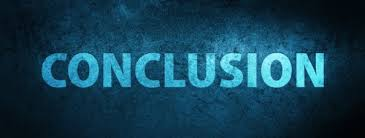



1.  With the Deep Learning model of CNN with three layers and dense layer, it was possible to train the model with accuracy of 97%.

2. Tried with different number of Epoch of 15 to see how network plateau and the accuracy is lesser than 30 Epoch.

3. Activation fucntion - relu and TanH both work fine with first giving 97% accuracy and second being 96 % accuracy.

4. Gradient estimation used are Stochastic gradient descent and RmsProp optimizer and network will plateau with accuracy of 97% for second and first SDG even after 30 epoch it has accuracy 67%

5. Tried with another Network Architecture with one extra layer got a output accuracy of 94% compared to other with one less layer with 97%

6. Tested with two different Network initialization one with TruncatedNormal and other being normal which default both network plateaued at 97%




## **Reference**



1.   Identifying Medical Diagnoses and Treatable Diseases by Image-Based Deep Learning - https://www.cell.com/cell/fulltext/S0092-8674(18)30154-5
2.   https://www.tensorflow.org/
3.   Dataset - Labeled Optical Coherence Tomography (OCT) and Chest X-Ray Images for Classification [link text](https://data.mendeley.com/datasets/rscbjbr9sj/2?__hstc=25856994.c1accec21e34f9e5905f815b5f26b6cf.1585211719596.1585211719596.1585297308307.2&__hssc=25856994.2.1585297308307&__hsfp=3321820689)



Copyright 2020 Abhishek Gargha Maheshwarappa

Permission is hereby granted, free of charge, to any person obtaining a copy of this software and associated documentation files (the "Software"), to deal in the Software without restriction, including without limitation the rights to use, copy, modify, merge, publish, distribute, sublicense, and/or sell copies of the Software, and to permit persons to whom the Software is furnished to do so, subject to the following conditions:

The above copyright notice and this permission notice shall be included in all copies or substantial portions of the Software.

THE SOFTWARE IS PROVIDED "AS IS", WITHOUT WARRANTY OF ANY KIND, EXPRESS OR IMPLIED, INCLUDING BUT NOT LIMITED TO THE WARRANTIES OF MERCHANTABILITY, FITNESS FOR A PARTICULAR PURPOSE AND NONINFRINGEMENT. IN NO EVENT SHALL THE AUTHORS OR COPYRIGHT HOLDERS BE LIABLE FOR ANY CLAIM, DAMAGES OR OTHER LIABILITY, WHETHER IN AN ACTION OF CONTRACT, TORT OR OTHERWISE, ARISING FROM, OUT OF OR IN CONNECTION WITH THE SOFTWARE OR THE USE OR OTHER DEALINGS IN THE SOFTWARE.